# ABOUT


Datascientest's Datascientist continuous bootcamp - cohorte Mars2022 -  AeroBOT project

**Tutor**

* Alban THUET

**Authors:**

* Hélène ASSIR
* Hichem HADJI  
* [Ioannis STASINOPOULOS](https://www.linkedin.com/in/ioannis-stasinopoulos/)

</br>

---
</br>

**Version History**

Version | Date       | Author(s)  | Modification
--------|----------- | ---------  | --------------------------
X.X     | XX/XX/2022 | A.B        | modif
1.1     | 04/07/2022 | I.S, H.A.  | Anomaly one-hot encoding
1.0     | 30/06/2022 | I.S, H.A.  | Document creation

This notebook can be executed entirely. 

It

* mounts the GDrive of our AeroBot project @gmail account.

* loads the data from the `train_data_final.pkl` file (cf. `0_test_set_creator_DO_NOT_MODIFY_20220630.ipynb`) under a pandas DataFrame named `df`, which contains `97417` entries and 96 columns.
These data do not contain any more UAS-related entries.

* Performs Feature Engineering: one-hot-encoding of Anomaly using a naive approache, looking directly for the root label into the multiple modalities string of Anomaly
* A comparison of 2 approaches (Naive vs Regex, more complex) was performed, but, with very limited discrepancies between the 2 approaches, we favored the naive one (see : ATTEMPT_1_main_DO_NOT_MODIFY_20220704_Anomaly_ReGex.ipynb).  

Further processing of the data should be perfomed on this dataframe, after having **copied a version of the present notebook**.

# IMPORT PACKAGES


settings for  full / patial Narrative display. Helene?


In [1]:
#######################
# Import packages
#######################
import numpy as np
import seaborn as sns
import math # for math.pi etc.
import time # time code execution

#######################
# Pandas
#######################
import pandas as pd
# Set pandas settings to show all data when using .head(), .columns etc.
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.set_option("display.colheader_justify","left") # left-justify the print output of pandas

### Display full columnwidth
# Set pandas settings to display full text columns
#pd.options.display.max_colwidth = None
# Restore pandas settings to display standard colwidth
pd.reset_option('display.max_colwidth')

import itertools # Pour créer des iterateurs

# Package to show the progression of pandas operations
from tqdm import tqdm
# from tqdm.auto import tqdm  # for notebooks

# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()
# simply use .progress_apply() instead of .apply() on your pd.DataFram

######################
# PLOTTING
######################
import matplotlib.pyplot as plt
%matplotlib inline
# Define global plot parameters for better readability and consistency among plots
# A complete list of the rcParams keys can be retrieved via plt.rcParams.keys() function
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.labelsize'] = 23
plt.rcParams['xtick.labelsize'] = 23
plt.rcParams['ytick.labelsize'] = 23
plt.rc('legend', fontsize=23)    # legend fontsize

# BOKEH 
from bokeh.plotting import figure # Importation de la classe figure qui permet de créer un graphique bokeh.
from bokeh.io import  push_notebook, output_notebook, show
output_notebook() # permet d'afficher tous les futurs graphiques dans l'output d'une cellule jupyter. Si cette instruction n'est pas lancée, la figure s'affichera dans un nouvel onglet.
from bokeh.models import ColumnDataSource
from bokeh.transform import dodge
from bokeh.models.tools import HoverTool

#####################
# NLP 
#####################
import re # for Regular Expression handling
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet') # WordNet lemmatizer
nltk.download('omw-1.4') # necessary for WordNet lemmatizer
from nltk.tokenize import word_tokenize # Usual tokenizer
from nltk.tokenize import TweetTokenizer # Special tokenizer;  "we'll", "didn't", etc. are considered as one word
from sklearn.feature_extraction.text import CountVectorizer # Vectorization
from nltk.corpus import stopwords # Import stopwords from nltk.corpus
from nltk.stem.snowball import EnglishStemmer

###############################
# ML preprocessing and models
###############################
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import ensemble # random forest
from sklearn.svm import SVC

# EVALUATION tools from sklearn
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, multilabel_confusion_matrix, average_precision_score, precision_recall_curve, PrecisionRecallDisplay

###############################
# Deep Learning
###############################
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras import callbacks


###############################
# Other
###############################
import pickle as pkl # Saving data externally

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


# LOAD FUNCTIONS

Functions common to several sections of this code (we should actually put them in a separate file and load them from there)

In [2]:
def plot_train_history(training_history, metric, anomaly_name):
  """
  Generete plots to monitor the train process
  Inputs: 
  - 'training_history'; use training_history = model.train(...)
  - 'metric' to plot; string e.g. 'accuracy', 'loss'
  - 'anomaly_name' e.g. 'Anomaly_Conflict'. This is used for the plot title
  """
  fig = plt.figure(figsize = (10,4))
  #plt.title(f"{anomaly_name} train history - {metric.upper()}", fontsize = 20)
  train_acc = training_history.history[metric]
  val_acc = training_history.history['val_' + metric] # e.g. 'val_accuracy'

  plt.plot(train_acc, label = f'Training {metric}')
  plt.plot(val_acc, label = f'Validation {metric}')
  plt.xlabel('epochs')
  plt.ylabel(f'{metric}')
  plt.legend()
  plt.show();

# LOAD DATA

## Mount GDrive

In [3]:
#@title
# Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive/')

#check your present working directory 
%pwd

Mounted at /content/drive/


'/content'

In [4]:
#@title
# move to the transformed data location (you can create a deeper structure, if needed, e.g. to save a trained model):
%cd /content/drive/MyDrive/data/transformed/

/content/drive/MyDrive/data/transformed


In [5]:
#@title
!ls # list the content of the pwd

#!ls "/content/drive/MyDrive/Data_Science/Formations/DataScienceTest/projet/AeroBot/" # list contect of a speficic folder

 complaints-2022-08-05_13_55.csv
'Copy of Qualified abbreviations_20220718.xlsx.gsheet'
'Data Dictionnary.xlsx'
 data_for_BERT_multilabel_20220805.pkl
 logs
 model.png
 model_results
 Narrative_PP_stemmed_24072022_TRAIN.pkl
 Narrative_Raw_Stemmed_24072022_TRAIN.pkl
 Narrative_RegEx_subst_21072022_TRAIN.pkl
'Qualified abbreviations_20220707_test.csv'
'Qualified abbreviations_20220708.csv'
'Qualified abbreviations_20220718.csv'
'Qualified abbreviations_20220718_Google_sheet.gsheet'
 test_data_final.pkl
 train_data_final.pkl


## Load data from .pkl file


In [6]:
#@title
# Load the TRAIN data (97417 entries)
# Do not touch the TEST data until the end of the project!
# or the curse of the greek gods will fall upon you!

%cd /content/drive/MyDrive/data/transformed/
with open("train_data_final.pkl", "rb") as f:
    loaded_data = pkl.load(f)

df = loaded_data[0]
print("\nA Dataframe with", len(df), "entries has been loaded")

/content/drive/MyDrive/data/transformed

A Dataframe with 97417 entries has been loaded


# NARRATIVE ENGINEERING

### Load the pre-processed Narrative data 

See the notebook that performs the substitutions

In [7]:
# Load the file Narrative_PP_stemmed_21072022_TRAIN.pkl
%cd /content/drive/MyDrive/data/transformed/
with open("Narrative_PP_stemmed_24072022_TRAIN.pkl", "rb") as f:
    loaded_narr = pkl.load(f)

df['Narrative_PP_stemmed'] = loaded_narr[0]
print("Data loaded")

/content/drive/MyDrive/data/transformed
Data loaded


In [8]:
# Load the file Narrative_PP_stemmed_21072022_TRAIN.pkl
%cd /content/drive/MyDrive/data/transformed/
with open("Narrative_Raw_Stemmed_24072022_TRAIN.pkl", "rb") as f:
    loaded_narr = pkl.load(f)

df['Narrative_Raw_Stemmed'] = loaded_narr[0]
print("Data loaded")

/content/drive/MyDrive/data/transformed
Data loaded


In [9]:
df.loc[1715282]['Narrative']

"I am writing this report to bring attention to the second departure frequency out of MDW last night. It is a safety issue to give us two frequency changes below 3;000 feet on departure out of MDW.We were in a heavy [aircraft] doing a full power; flaps 25; bleeds off takeoff off of 22L. These takeoffs are known to have very high climb rates; so the intermediate level-off of 3;000 feet approaches fast. At 1;000 feet; we're instructed to contact Departure on 128.2. Simultaneously; I switch frequencies and retract flaps as commanded by the pilot flying. Upon checking in with 128.2; he instructs us to climb and maintain 4;000 feet and subsequently contact 126.62. I dial in 4;000 feet and continue to retract flaps while monitoring a level-off from a climb rate of over 2;000 FPM. At this point; my head turns down to the radio to dial the new Departure frequency in. I check in and they tell us to climb and maintain 12;000 feet. I dial in 12;000 feet; confirm it; reset the autobrake and gear l

In [10]:
df.loc[1715282]['Narrative_PP_stemmed'][:20]

['write',
 'report',
 'bring',
 'attent',
 'second',
 'departur',
 'frequenc',
 'mdw',
 'last',
 'night',
 'safeti',
 'issu',
 'give',
 'us',
 'two',
 'frequenc',
 'chang',
 '3',
 '000',
 'feet']

In [11]:
df.loc[1715282]['Narrative_Raw_Stemmed'][:20]

['write',
 'report',
 'bring',
 'attent',
 'second',
 'departur',
 'frequenc',
 'mdw',
 'last',
 'night',
 'safeti',
 'issu',
 'give',
 'us',
 'two',
 'frequenc',
 'chang',
 '3',
 '000',
 'feet']

# TARGET FEATURE ENGINEERING

## Anomaly

This section 

*   drops the entries with NaN in 'Anomaly'
*   creates and adds to the DataFrame 'df' a one-hot column for each Anomaly root label

Root labels are as defined in the ASRS coding form.pdf

We use a naive approach using string parsing 

### Drop the NaNs in Anomaly

In [12]:
# Drop Anomaly NaN's
print(f"We have {len(df[df['Anomaly'].isna()])} entries where 'Anomaly' == NaN. We drop these entries")

df = df.dropna(axis = 0, how = 'any', subset = ['Anomaly'])
print(f"Current length of our DataFrame: {len(df)}")

We have 431 entries where 'Anomaly' == NaN. We drop these entries
Current length of our DataFrame: 96986


### One-hot encode Anomaly root labels

In [13]:
# Root label (source = ASRS coding forms)
Anomaly_RootLabels=['Aircraft Equipment',
                    'Airspace Violation',
                    'ATC Issue',
                    'Flight Deck / Cabin / Aircraft Event',
                    'Conflict',
                    'Deviation - Altitude',
                    'Deviation - Speed',
                    'Deviation - Track / Heading',
                    'Deviation / Discrepancy - Procedural',
                    'Ground Excursion',
                    'Ground Incursion',
                    'Ground Event / Encounter',
                    'Inflight Event / Encounter',
                    'No Specific Anomaly Occurred']

#### Naive one-hot encoding

In [14]:
# Create a column in the df corresponding to each Anomaly root label 'anomaly_rl'
Anomaly_RootLabels_columns = []
for anomaly_rl in Anomaly_RootLabels:
    col='Anomaly_' + anomaly_rl
    Anomaly_RootLabels_columns.append(col)
    # Fill the columns in a one-hot-encoding logic
    df[col] = df['Anomaly'].astype('str').apply(lambda x: 1 if (anomaly_rl in x)  else 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [15]:
for anomaly_rl in Anomaly_RootLabels:
    col='Anomaly_'+anomaly_rl
    print('\n',col,'\n',df[col].value_counts())


 Anomaly_Aircraft Equipment 
 0    59054
1    37932
Name: Anomaly_Aircraft Equipment, dtype: int64

 Anomaly_Airspace Violation 
 0    92989
1     3997
Name: Anomaly_Airspace Violation, dtype: int64

 Anomaly_ATC Issue 
 0    81232
1    15754
Name: Anomaly_ATC Issue, dtype: int64

 Anomaly_Flight Deck / Cabin / Aircraft Event 
 0    89839
1     7147
Name: Anomaly_Flight Deck / Cabin / Aircraft Event, dtype: int64

 Anomaly_Conflict 
 0    79622
1    17364
Name: Anomaly_Conflict, dtype: int64

 Anomaly_Deviation - Altitude 
 0    88110
1     8876
Name: Anomaly_Deviation - Altitude, dtype: int64

 Anomaly_Deviation - Speed 
 0    94398
1     2588
Name: Anomaly_Deviation - Speed, dtype: int64

 Anomaly_Deviation - Track / Heading 
 0    88707
1     8279
Name: Anomaly_Deviation - Track / Heading, dtype: int64

 Anomaly_Deviation / Discrepancy - Procedural 
 1    58337
0    38649
Name: Anomaly_Deviation / Discrepancy - Procedural, dtype: int64

 Anomaly_Ground Excursion 
 0    94829
1     

In [16]:
# Plots
# # Parsing de la colonne 'Anomaly' et top 200 des modalités selon le 1/0 encoding
# for anomaly_rl in Anomaly_RootLabels:
#     col='Anomaly_'+anomaly_rl
    
#     title_plot=col +' : ' + str(sum(df[col]))+' entries of our DF'
#     Anomaly=df[df[col]==1]['Anomaly'].str.split('; ', expand=True).stack().reset_index(drop=True)
#     fig, ax = plt.subplots(figsize=(15,30))
#     sns.countplot(y=Anomaly, order=Anomaly.value_counts().iloc[:50].index,color='green').set(title=title_plot);

#     title_plot='NO '+col +' : ' + str(len(df)-sum(df[col]))+' entries of our DF'
#     Anomaly=df[df[col]==0]['Anomaly'].str.split('; ', expand=True).stack().reset_index(drop=True)
#     fig, ax = plt.subplots(figsize=(15,30))
#     sns.countplot(y=Anomaly, order=Anomaly.value_counts().iloc[:50].index,color='red').set(title=title_plot);

# Padding ratio

Some statistical considerations concerning narrative length (measured in # of tokens) vs. pad length.


Usefull for WordEmbedding algorithms

In [17]:
# Examine typical narrative length to get an idea about the padding / truncating step
df['Narrative_PP_stemmed_len'] = df['Narrative_PP_stemmed'].apply(lambda x: len(x))
df['Narrative_PP_stemmed_len'].describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


count    96986.000000
mean       143.628379
std        106.181102
min          1.000000
25%         72.000000
50%        117.000000
75%        185.000000
max       1317.000000
Name: Narrative_PP_stemmed_len, dtype: float64

Positive: narrative is longer than maxlen; there is no padding

Negative: narrative is shorter than maxlen; we have padding.

the more negative the ratio, the more padding there is. It cannot get more negative than -1.0



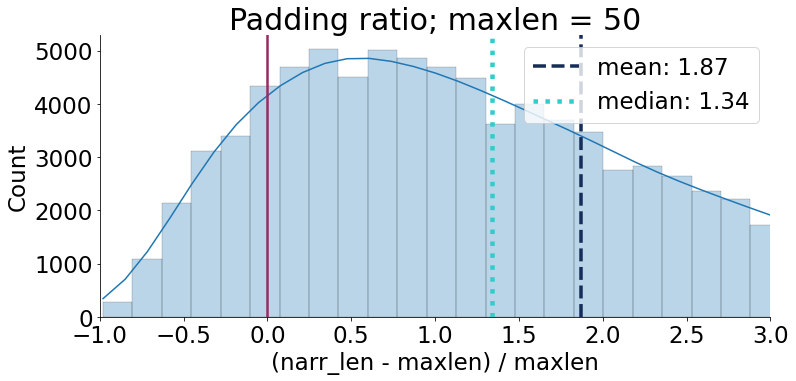

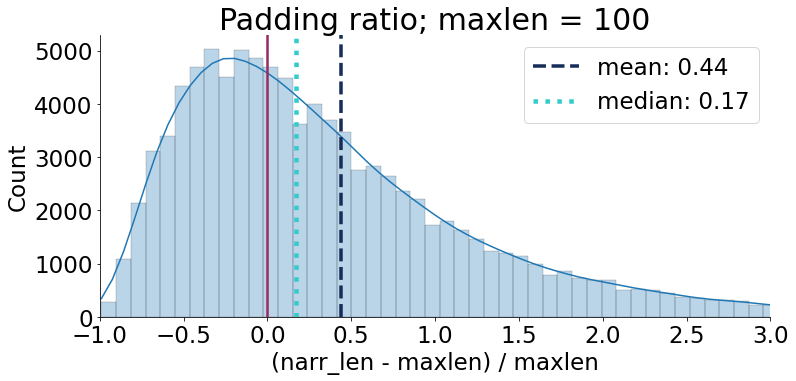

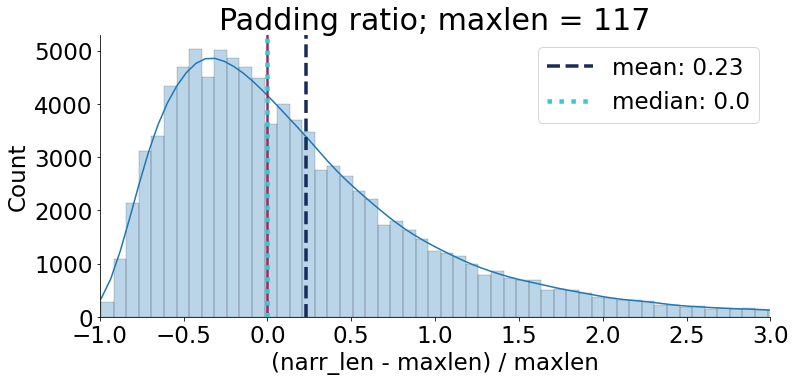

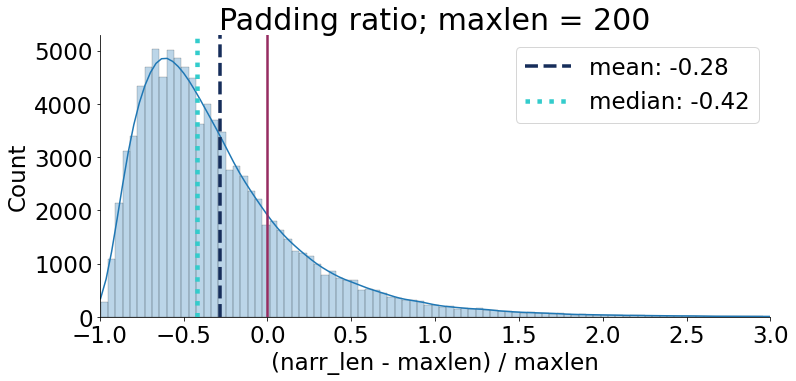

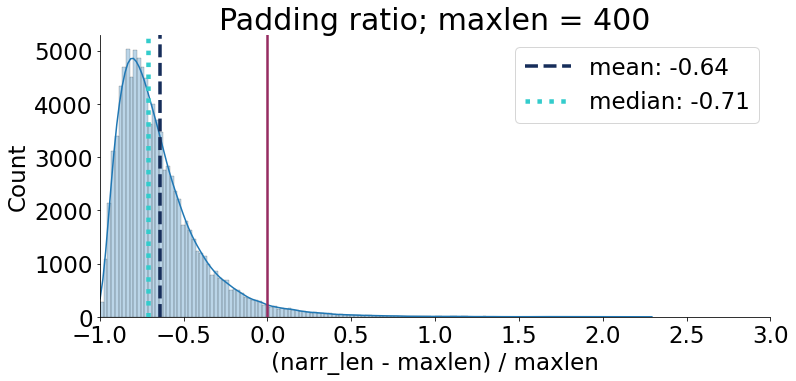

In [18]:
maxlen = 200 # length of the text vector (in words). Will ignore narrative content beyond this limit

# Plot histograms
print("Positive: narrative is longer than maxlen; there is no padding\n")
print("Negative: narrative is shorter than maxlen; we have padding.\n")
print("the more negative the ratio, the more padding there is. It cannot get more negative than -1.0\n")

for maxlen in [50, 100, 117, 200, 400]:
  pad_ratio = df['Narrative_PP_stemmed_len'].apply(lambda x: (x - maxlen) / maxlen)

  sns.displot(pad_ratio, bins = 150, kde = True, alpha  = 0.3)
  plt.xlim([-1,3])
  plt.gcf().set_size_inches(15, 5)

  # Plot mean, median as vertical lines
  mean = np.round(pad_ratio.mean(),2)
  median = np.round(pad_ratio.median(),2)
  plt.axvline(x = 0, color = '#962c61', ls='-', lw = 2.5)
  plt.axvline(x = mean, color = '#162d5a', ls='--', lw = 3.5, label = f'mean: {mean}')
  plt.axvline(x = median, color = '#33cccc', ls='dotted', lw = 4.5, label = f'median: {median}')

  plt.xlabel('(narr_len - maxlen) / maxlen')
  plt.title(f'Padding ratio; maxlen = {maxlen}')
  plt.legend();

# Multilabel with BERT


# 🤗 Hugging Face 

In [19]:
! pip install transformers 
! pip install datasets 
! pip install huggingface_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 26.0 MB/s 
     |████████████████████████████████| 120 kB 71.6 MB/s 
     |████████████████████████████████| 6.6 MB 68.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 365 kB 24.2 MB/s 
     |████████████████████████████████| 115 kB 77.9 MB/s 
     |████████████████████████████████| 212 kB 60.9 MB/s 
     |████████████████████████████████| 127 kB 56.8 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Data preparation

In [20]:
anomalies = [ 'Anomaly_Aircraft Equipment', 
              'Anomaly_Airspace Violation',
              'Anomaly_ATC Issue', 
              'Anomaly_Flight Deck / Cabin / Aircraft Event',
              'Anomaly_Conflict', 
              'Anomaly_Deviation - Altitude',
              'Anomaly_Deviation - Speed', 
              'Anomaly_Deviation - Track / Heading',
              'Anomaly_Deviation / Discrepancy - Procedural',
              'Anomaly_Ground Excursion', 
              'Anomaly_Ground Incursion',
              'Anomaly_Ground Event / Encounter',
              'Anomaly_Inflight Event / Encounter',
              'Anomaly_No Specific Anomaly Occurred']
# I got this list from df.columns
# 14 labels

In [21]:
# # Join all tokens into a single string
# df['Narrative_PP_stemmed_str'] = df['Narrative_PP_stemmed'].apply(lambda token_list: ' '.join(entry for entry in token_list))

We input the raw narratives!

In [22]:
# THIS WORKS
temp_df = df[anomalies]

temp_df['labels']  = temp_df.apply(lambda r: tuple(r), axis=1).apply(np.array)
# has to be 'labels' and not 'label'. HuggingFace expects this. 
# With 'label', I got AssertError in the conversion to tf.dataset
temp_df = temp_df.drop(columns = anomalies)
temp_df['text'] = df['Narrative']
temp_df = temp_df.reset_index().drop(columns = ['ACN'])

temp_df.head(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,labels,text
0,"[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",I was the pilot flying performing the takeoff....
1,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",We had 6 shipments of dry ice for the flight; ...


In [23]:
# Train-test split  
temp_df_train_plus_val, temp_df_test, = train_test_split(temp_df, 
                                                test_size= 0.2,
                                                random_state = 12) 

# Train-validation split 
temp_df_train, temp_df_validation, = train_test_split(temp_df_train_plus_val, 
                                                test_size= 0.2,
                                                random_state = 12) 

temp_df_train.head(3)

print("train set length:", len(temp_df_train))
print("validation set length:", len(temp_df_validation))
print("test set length:", len(temp_df_test))

train set length: 62070
validation set length: 15518
test set length: 19398


### Convert to a 🤗 dataset

In [24]:
from datasets import Dataset, DatasetDict
# use from_dict() and not from_pandas(); otherwise you get an extra key, smth litke '__index col__'
train_dataset = Dataset.from_dict(temp_df_train)
validation_dataset = Dataset.from_dict(temp_df_validation)
test_dataset = Dataset.from_dict(temp_df_test)

# inspect this object
train_dataset

Dataset({
    features: ['labels', 'text'],
    num_rows: 62070
})

In [25]:
# Inspect the label format
train_dataset['labels'][:3]

[[0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]]

In [26]:
# 'merge' the two 🤗 datasets into one
dataset = DatasetDict({"train": train_dataset, 
                       "validation": validation_dataset, 
                       "test": test_dataset})

dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 62070
    })
    validation: Dataset({
        features: ['labels', 'text'],
        num_rows: 15518
    })
    test: Dataset({
        features: ['labels', 'text'],
        num_rows: 19398
    })
})

In [27]:
# Inspect the two keys
print(dataset['train'].features)
print(dataset['validation'].features)
print(dataset['test'].features, '\n')

# To access an actual element, select a split first, then give an index:
print(dataset["train"][0])

{'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'text': Value(dtype='string', id=None)}
{'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'text': Value(dtype='string', id=None)}
{'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'text': Value(dtype='string', id=None)} 

{'labels': [0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], 'text': "I was working RADAR and had Citation X descending into the SEF airport. The pilot was approximately 10-12 miles away from the airport and reported that he had the field in sight. I cleared the aircraft for a visual approach. Just after I issued the clearance; I terminated RADAR service and cleared him to the airport advisory frequency. I thought the aircraft was close enough to the field to proceed straight in and land. Instead the aircraft took a hard left turn which I was not expecting; presumably to set up for landing on whichever runway he was using. This hard lef

### Choose the model

In [28]:
# Name of the BERT model to use
model_name = "google/bert_uncased_L-12_H-768_A-12" # this is BERT BASE

#"google/bert_uncased_L-12_H-128_A-2"
 
# This is one of the Small BERTs. I chose the one with L = 12 (because we have technical terms)
# and the smallest H, to reduce training time

### Tokenize with pretrained tokenizer

In [29]:
# TOKENIZE using a pre-trained tokenizer from HuggingFace
from transformers import AutoTokenizer

# instantiate tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Define a function in order to use .map() below
max_length = 200
def tokenize_function(examples):
  return tokenizer(examples["text"], 
                    padding='max_length', max_length = max_length, # same value as we used for WordEmbedding 
                    truncation = True
                    #return_tensors="tf"
                    )

# Auxialiary variable, see below
pre_tokenizer_columns = set(dataset["train"].features)

# map the tokenization function onto our dataset
# it is ok to apply it also to the test set, since it is a *pretrained* tokenizer,
# i.e. it will not train on our data
tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Display the additional columns created by the tokenizer
# They are necessary inputs for BERT
tokenizer_columns = list(set(tokenized_dataset["train"].features) - pre_tokenizer_columns)
print("Columns added by tokenizer:", tokenizer_columns)

  0%|          | 0/63 [00:00<?, ?ba/s]

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/20 [00:00<?, ?ba/s]

Columns added by tokenizer: ['input_ids', 'attention_mask', 'token_type_ids']


In [30]:
# inspect 
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 62070
    })
    validation: Dataset({
        features: ['labels', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 15518
    })
    test: Dataset({
        features: ['labels', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 19398
    })
})

## Fine-tuning the model

### Download the model

Now that our data is ready, we can download the pretrained model and fine-tune it. Like with the tokenizer, the from_pretrained method will download and cache the model for us. The only thing we have to specify is the number of labels for our problem

From [HuggingFace](https://huggingface.co/docs/transformers/model_doc/bert): 

BertConfig is the configuration class to store the configuration of a BertModel (Pytorch) or a TFBertModel (TensorFlow). It is used to instantiate a BERT model according to the specified arguments, defining the model architecture. Instantiating a configuration with the defaults will yield a similar configuration to that of the BERT bert-base-uncased architecture.

Configuration objects inherit from PretrainedConfig and can be used to control the model outputs. Read the documentation from PretrainedConfig for more information.

Difference between AutoConfig, AutoTokenizer etc. vs. BertConfig, BertTokenizer etc.:

[forum entry](https://github.com/huggingface/transformers/issues/5587) --> Use AutoXXX for more flexibility regarding model checkpoints

In [31]:
num_classes = len(anomalies)

from transformers import AutoConfig
# Load transformers config and set output_hidden_states to False
config = AutoConfig.from_pretrained(model_name)
# Loading a model from its configuration file does not load the model weights. 
# It only affects the model’s configuration. Use from_pretrained() to load the model weights

config.output_hidden_states = True # we want access to the hidden states' outputs
config.num_labels = num_classes

In [32]:
config

BertConfig {
  "_name_or_path": "google/bert_uncased_L-12_H-768_A-12",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_10": 10,
    "LABEL_11": 11,
    "LABEL_12": 12,
    "LABEL_13": 13,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8,
    "LABEL_9": 9
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 1

In [33]:
# # Load BERT tokenizer
# tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path = model_name, config = config)

from transformers import TFAutoModel
# Loading a model from its configuration file does not load the model weights. 
# It only affects the model’s configuration. Use from_pretrained() to load the model weights

# Load the Transformers BERT model
transformer_model = TFAutoModel.from_pretrained(model_name, config = config, from_pt = True) 
# pass our configuration

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint

#### Freeze BERT's layers

In [34]:
transformer_model.layers

In [35]:
# Make layers (un)trainable
# This gives the whole bert base model and sets all layers' trainable attribute at once
for layer in transformer_model.layers: # this is the main layer
    layer.trainable = True # you have to set this to true and then the 
# See this post:
# https://discuss.huggingface.co/t/fine-tune-bert-models/1554/6

# HOW TO CONTROL THE INDIVIDUAL 12 LAYERS?
# see https://stackoverflow.com/questions/71336067/how-to-freeze-some-layers-of-bert-in-fine-tuning-in-tf2-keras
nb_layers = len(transformer_model.bert.encoder.layer)
print("Number of layers (should be 12 for BERT):", nb_layers)

for layer in transformer_model.bert.encoder.layer[:8]:
  layer.trainable = False

Number of layers (should be 12 for BERT): 12


In [36]:
for i in range(nb_layers):
  print(f"Layer {i} trainable:", transformer_model.bert.encoder.layer[i].trainable)

Layer 0 trainable: False
Layer 1 trainable: False
Layer 2 trainable: False
Layer 3 trainable: False
Layer 4 trainable: False
Layer 5 trainable: False
Layer 6 trainable: False
Layer 7 trainable: False
Layer 8 trainable: True
Layer 9 trainable: True
Layer 10 trainable: True
Layer 11 trainable: True


**Observe in the model.summary() below, the number of trainable vs. non-trainable parameters.**

### Build the model

In [37]:
tf.keras.backend.clear_session()

# Build your model input
input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')

outputs = transformer_model(input_ids)

#### Construct the output of BERT, as desired

In [38]:
outputs

TFBaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=<KerasTensor: shape=(None, 200, 768) dtype=float32 (created by layer 'tf_bert_model')>, pooler_output=<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'tf_bert_model')>, past_key_values=None, hidden_states=(<KerasTensor: shape=(None, 200, 768) dtype=float32 (created by layer 'tf_bert_model')>, <KerasTensor: shape=(None, 200, 768) dtype=float32 (created by layer 'tf_bert_model')>, <KerasTensor: shape=(None, 200, 768) dtype=float32 (created by layer 'tf_bert_model')>, <KerasTensor: shape=(None, 200, 768) dtype=float32 (created by layer 'tf_bert_model')>, <KerasTensor: shape=(None, 200, 768) dtype=float32 (created by layer 'tf_bert_model')>, <KerasTensor: shape=(None, 200, 768) dtype=float32 (created by layer 'tf_bert_model')>, <KerasTensor: shape=(None, 200, 768) dtype=float32 (created by layer 'tf_bert_model')>, <KerasTensor: shape=(None, 200, 768) dtype=float32 (created by layer 'tf_bert_model')>, <KerasTen

In [39]:
outputs['hidden_states']
# There are 13 elements
# index 0 of the tuple hidden_states = initial embedding output 
# (sum of the token embedding, segment embedding, position embedding)

# The remaining 12 elements in the tuple contain the output of the corresponding hidden layer. 

(<KerasTensor: shape=(None, 200, 768) dtype=float32 (created by layer 'tf_bert_model')>,
 <KerasTensor: shape=(None, 200, 768) dtype=float32 (created by layer 'tf_bert_model')>,
 <KerasTensor: shape=(None, 200, 768) dtype=float32 (created by layer 'tf_bert_model')>,
 <KerasTensor: shape=(None, 200, 768) dtype=float32 (created by layer 'tf_bert_model')>,
 <KerasTensor: shape=(None, 200, 768) dtype=float32 (created by layer 'tf_bert_model')>,
 <KerasTensor: shape=(None, 200, 768) dtype=float32 (created by layer 'tf_bert_model')>,
 <KerasTensor: shape=(None, 200, 768) dtype=float32 (created by layer 'tf_bert_model')>,
 <KerasTensor: shape=(None, 200, 768) dtype=float32 (created by layer 'tf_bert_model')>,
 <KerasTensor: shape=(None, 200, 768) dtype=float32 (created by layer 'tf_bert_model')>,
 <KerasTensor: shape=(None, 200, 768) dtype=float32 (created by layer 'tf_bert_model')>,
 <KerasTensor: shape=(None, 200, 768) dtype=float32 (created by layer 'tf_bert_model')>,
 <KerasTensor: shape=

In [40]:
outputs['last_hidden_state']

<KerasTensor: shape=(None, 200, 768) dtype=float32 (created by layer 'tf_bert_model')>

In [41]:
outputs['last_hidden_state'][:, 0, :]

<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'tf.__operators__.getitem')>

In [42]:
# Previously, we did this:
#net = outputs['last_hidden_state'][:, 0, :] # see notes on model outputs

# Current approach:
# Concatenate several layers to extend the embedding of each word
net = tf.keras.layers.Concatenate(axis = -1)([outputs['hidden_states'][9],
                                              outputs['hidden_states'][10],
                                              outputs['hidden_states'][11]]) 
# -1 means last dim

print(net.shape)

(None, 200, 2304)


In [43]:
# Keep the embedding of the CLS token only
net = net[:, 0, :]
print(net.shape)

(None, 2304)


#### Dense network for classification

In [44]:
#net = Dense(units = 512, activation='relu', name='dense1')(net)
#net = Dropout(rate = 0.2)(net)
#net = Dense(units = 256, activation='relu', name='dense2')(net)
#net = Dropout(rate = 0.2)(net)
#net = Dense(units = 128, activation='relu', name='dense3')(net)
#net = Dropout(rate = 0.2)(net)
#net = Dense(units = 64, activation='relu', name='dense4')(net)
#net = Dropout(rate = 0.2)(net)
net = Dense(units = 32, activation='relu', name='dense5')(net)
#net = Dropout(rate = 0.2)(net)
class_out = Dense(units = num_classes, activation='sigmoid', name='classifier')(net)

# Combine it all in a model object
model = Model(inputs=input_ids, outputs = class_out, name='BERT_MULTILABEL_classification')

# Take a look at the model
model.summary()

Model: "BERT_MULTILABEL_classification"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 200)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]']              
                                thPoolingAndCrossAt                                               
                                tentions(last_hidde                                               
                                n_state=(None, 200,                                               
                                 768),                                                            
                                 pooler_output=(Non                  

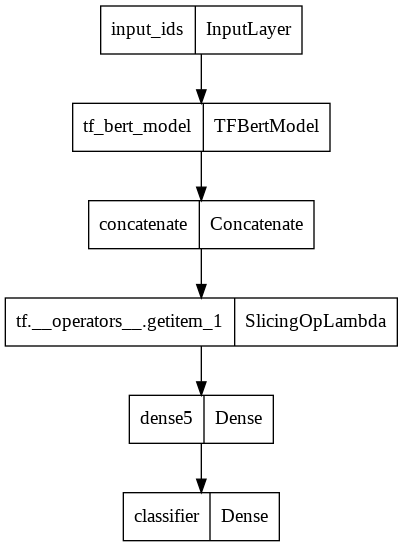

In [45]:
tf.keras.utils.plot_model(model)

### Convert dataset to TensorFlow format

Next, we convert our datasets to `tf.data.Dataset`, which Keras understands natively. There are two ways to do this - we can use the slightly more low-level [`Dataset.to_tf_dataset()`](https://huggingface.co/docs/datasets/package_reference/main_classes#datasets.Dataset.to_tf_dataset) method, or we can use [`Model.prepare_tf_dataset()`](https://huggingface.co/docs/transformers/main_classes/model#transformers.TFPreTrainedModel.prepare_tf_dataset). The main difference between these two is that the `Model` method can inspect the model to determine which column names it can use as input, which means you don't need to specify them yourself. Unless our samples are all the same length, we will also need to pass a `tokenizer` or `collate_fn` so that the `tf.data.Dataset` knows how to pad and combine samples into a batch.

In [46]:
# Convert Huggingface datasets to TF datasets
batch_size = 32

# Instantiate a data_collator
from transformers import DefaultDataCollator
data_collator = DefaultDataCollator(return_tensors="tf")

tf_train_dataset = tokenized_dataset["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["labels"],
    shuffle=True,
    collate_fn = data_collator,
    batch_size=batch_size)

tf_validation_dataset = tokenized_dataset["validation"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["labels"],
    shuffle=False,
    collate_fn = data_collator,
    batch_size=batch_size)

tf_test_dataset = tokenized_dataset["test"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["labels"],
    shuffle=False,
    collate_fn = data_collator,
    batch_size=batch_size)

In [47]:
tf_train_dataset

<PrefetchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 200), dtype=tf.int64, name=None), 'token_type_ids': TensorSpec(shape=(None, 200), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 200), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, 14), dtype=tf.int64, name=None))>

### Compile & Fit

In [48]:
## OPTIMIZER No 1
# # Set an optimizer; see HuggingFace tutorial for AdamW alternative
# optimizer = keras.optimizers.Adam(
#     learning_rate=5e-05,
#     epsilon=1e-08,
#     decay=0.01,
#     clipnorm=1.0)

#####################################
## OPTIMIZER No 2 - AdamW
# The create_optimizer function in the Transformers library creates a very useful 
# AdamW optimizer with weight and learning rate decay. This performs very well 
# for training most transformer networks - we recommend using it as your default 
# unless you have a good reason not to! Note, however, that because it decays 
# the learning rate over the course of training, 
# it needs to know how many batches it will see during training.
from transformers import create_optimizer
# Creates an optimizer with a learning rate schedule using a warmup phase followed by a linear decay.

num_epochs = 20
batches_per_epoch = len(tokenized_dataset["train"]) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)

optimizer, schedule = create_optimizer(init_lr=2e-5, 
                                       # The initial learning rate for the schedule after the warmup (so this will be the learning rate at the end of the warmup)
                                       num_warmup_steps=0,
                                       num_train_steps=total_train_steps)
# see https://huggingface.co/docs/transformers/main_classes/optimizer_schedules#transformers.create_optimizer

# Try these parameters ?
# init_lr = 2e-3
# num_warmup_steps=0.1 * total_train_steps


######################################
## OPTIMIZER No 3 - Simple Adam
# Should be enough if we train only the Dense network, right?
# optimizer = keras.optimizers.Adam() 

# Set loss and metrics
loss = tf.keras.losses.BinaryCrossentropy(from_logits = False) 
# value in [-inf, inf] when from_logits=True or a probability (i.e, value in [0., 1.] when from_logits = False).

metric = tf.keras.metrics.BinaryAccuracy('binary_accuracy') # 'binary_accuracy' calculates how often predictions match binary labels.

# Compile the model
model.compile(optimizer = optimizer,
              loss = loss, 
              metrics = metric)


In [49]:
# Define CALLBACKS
TON = callbacks.TerminateOnNaN() # Callback that terminates training when a NaN loss is encountered

early_stopping = callbacks.EarlyStopping(monitor = 'val_binary_accuracy', # 'binary_accuracy' calculates how often predictions match binary labels.
                                        min_delta=0.005,
                                        patience = 3, 
                                        mode = 'max', 
                                        restore_best_weights = True, 
                                        verbose = 1)

In [50]:
#num_epochs = 20 # defined in the optiimer, above

# Time the function execution
start_time = time.time()
print(7*'-', f"Execution started...", 7*'-')

training_history = model.fit(x = tf_train_dataset,
                             validation_data = tf_validation_dataset,
                             epochs = num_epochs, 
                             callbacks = [TON, early_stopping],
                             verbose = 1) # use verbose 1 to show the progress bar

# Calculate and print time to execute
print(7*'-', f"Execution finished!", 7*'-')
end_time = time.time()
print(f"--- It took {np.round((end_time - start_time)/60,1)} minutes --- \n\n")

------- Execution started... -------
Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['token_type_ids', 'attention_mask'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1940/1940 [==============================] - 2169s 1s/step - loss: 0.2219 - binary_accuracy: 0.9134 - val_loss: 0.1786 - val_binary_accuracy: 0.9296
Epoch 2/20
1940/1940 [==============================] - 2151s 1s/step - loss: 0.1724 - binary_accuracy: 0.9319 - val_loss: 0.1668 - val_binary_accuracy: 0.9342
Epoch 3/20
1940/1940 [==============================] - 2150s 1s/step - loss: 0.1590 - binary_accuracy: 0.9372 - val_loss: 0.1627 - val_binary_accuracy: 0.9357
Epoch 4/20
1940/1940 [==============================] - 2152s 1s/step - loss: 0.1494 - binary_accuracy: 0.9409 - val_loss: 0.1595 - val_binary_accuracy: 0.9373
Epoch 5/20
1940/1940 [==============================] - 2153s 1s/step - loss: 0.1410 - binary_accuracy: 0.9443 - val_loss: 0.1593 - val_binary_accuracy: 0.9376
Epoch 6/20
1940/1940 [==============================] - 2150s 1s/step - loss: 0.1334 - binary_accuracy: 0.9472 - val_loss: 0.1612 - val_binary_accuracy: 0.9368
Epoch 6: early stopping
------- Execution finished!

In [51]:
def plot_train_history(training_history, metric, anomaly_name):
  """
  Generete plots to monitor the train process
  Inputs: 
  - 'training_history'; use training_history = model.train(...)
  - 'metric' to plot; string e.g. 'accuracy', 'loss'
  - 'anomaly_name' e.g. 'Anomaly_Conflict'. This is used for the plot title
  """
  fig = plt.figure(figsize = (10,4))
  #plt.title(f"{anomaly_name} train history - {metric.upper()}", fontsize = 20)
  train_acc = training_history.history[metric]
  val_acc = training_history.history['val_' + metric] # e.g. 'val_accuracy'

  plt.plot(train_acc, label = f'Training {metric}')
  plt.plot(val_acc, label = f'Validation {metric}')
  plt.xlabel('epochs')
  plt.ylabel(f'{metric}')
  plt.legend()
  plt.show();

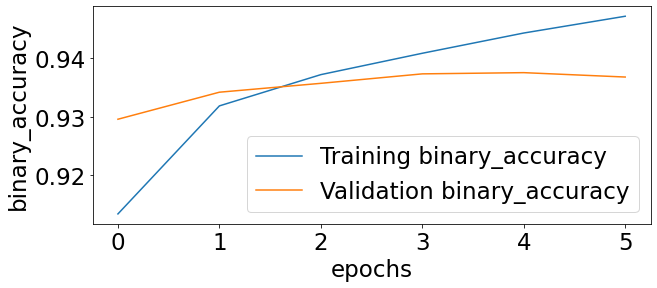

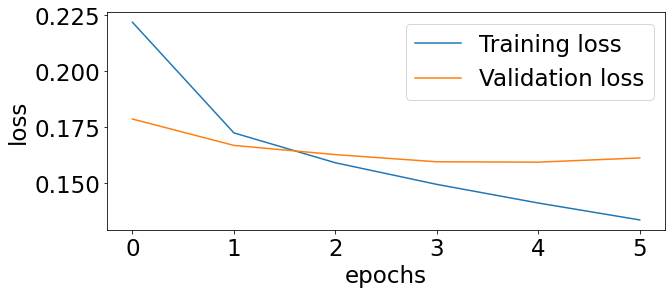

In [52]:
# Plot the train history
plot_train_history(training_history, 'binary_accuracy', '')
plot_train_history(training_history, 'loss', '')

## Infer

In [53]:
model_eval = model.evaluate(tf_test_dataset)

607/607 [==============================] - 247s 407ms/step - loss: 0.1637 - binary_accuracy: 0.9352


In [ ]:
y_pred_proba = model.predict(tokenized_dataset["test"]['input_ids'], 
                            batch_size = batch_size, 
                            verbose = 1)
y_pred_proba.shape 

In [ ]:
y_pred_proba[0] # probabilities

In [ ]:
def y_prob_to_y_pred_ML(y_pred_proba, threshold = 0.5):
  """
  Converts probabilities into 0's and 1's. We are still in the MULTILABEL context.
  Input: MULTILABEL predictions (probabilities whose sum for each sample may exceed > 1) coming directly from the model
  Using a user-defined threshold, return a MULTILABEL prediction vector 'y_pred' containing 0's and 1's
  """
  y_pred=[]
  for sample in y_pred_proba:
    y_pred.append([1 if i>= threshold else 0 for i in sample])
  y_pred = np.array(y_pred)

  return y_pred

In [57]:
y_pred = y_prob_to_y_pred_ML(y_pred_proba, threshold = 0.5) # call the function

In [ ]:
y_test = tokenized_dataset["test"]['labels']
y_test[0]

In [59]:
print(classification_report(y_test, y_pred, target_names = anomalies))

                                              precision    recall  f1-score   support

                  Anomaly_Aircraft Equipment       0.89      0.84      0.86      7666
                  Anomaly_Airspace Violation       0.75      0.46      0.57       804
                           Anomaly_ATC Issue       0.73      0.71      0.72      3165
Anomaly_Flight Deck / Cabin / Aircraft Event       0.85      0.65      0.74      1515
                            Anomaly_Conflict       0.80      0.79      0.79      3464
                Anomaly_Deviation - Altitude       0.75      0.61      0.67      1732
                   Anomaly_Deviation - Speed       0.65      0.35      0.46       525
         Anomaly_Deviation - Track / Heading       0.69      0.57      0.63      1610
Anomaly_Deviation / Discrepancy - Procedural       0.79      0.83      0.81     11651
                    Anomaly_Ground Excursion       0.62      0.69      0.66       437
                    Anomaly_Ground Incursion       0.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Save the model

In [60]:
# Save the model
# The file takes some time to appear on the Drive
# MAKE SURE YOU HAVE CREATED THE DIRECTORY!
experiment_name = '2022_09_12_7_5_2_1_concat_layers_9_10_11_UNfrozen'
dir_name = '/content/drive/MyDrive/data/saved models/Yannis/' + experiment_name
%cd $dir_name

filename = experiment_name + '.pkl'
pkl.dump(model, open(filename, 'wb'))

/content/drive/MyDrive/data/saved models/Yannis/2022_09_12_7_5_2_1_concat_layers_9_10_11_UNfrozen


In [ ]:
# Save y_test and most importantly, y_pred_proba
# with this you can reconstruct the multilabel classif report or the PR curve
filename = 'y_test_' + experiment_name + '.pkl'
pkl.dump(y_test, open(filename, 'wb'))

filename = 'y_pred_proba_' + experiment_name + '.pkl'
pkl.dump(y_pred_proba, open(filename, 'wb'))

# Evaluate - BINARY context

In [ ]:
def y_multilabel_to_binary(y_test, y_pred_proba, cls_idx):
  """
  For a given class with index 'cls_idx', convert true labels and predicted 
  probabilities from multilabel to binary classification format.
  Used to plot Receiver-Operating Curves (ROCs)

  Inputs:
  - y_test: ndarray, shape (#samples, # classes) containing 0 or 1, e.g. array([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
    Each row may contain several '1' (multilabel)
  - y_pred_proba: ndarray, shape (#samples, # classes) containing probabilities for each class, as return from our model. 
    The probabilities for a given sample may sum to >1 in multilabel problems.
  - cls_idx: class index (int). Pick the class of interest.

  Return
  - y_test_cls: true labels for the given class
  - probs_cls: probabilities for the given class
  """
  # Initialize variables
  y_test_cls = []
  probs_cls = []

  for i in range(len(y_test)): # Loop through the input test-set
    # Pick the values corresponding to the class of interest
    y_test_cls.append(y_test[i][cls_idx])
    probs_cls.append(y_pred_proba[i][cls_idx])

  y_test_cls = np.array(y_test_cls)
  probs_cls = np.array(probs_cls)

  return y_test_cls, probs_cls

#### Precision-Recall (PR) curve

Plot precision-recall curve that is suitable for IMBALANCED datasets

see https://www.kaggle.com/code/kmkarakaya/multi-label-model-evaluation/notebook

##### Determine the optimal threshold from PR curve

In [ ]:
def find_opt_threshold_PR(precision, recall, thresholds):
  """
  Find the optimal threshold in a given Precision Recall (PR) Curve
  by determining the threshold that yields the min distance to the top-right
  point (1,1) of the PR curve.

  Returns the threshold value
  """
  dist = [] # distance from the point (precision = 1; recall = 1)
  for p, r in zip(precision, recall):
    dist.append(np.sqrt( (1 - p)**2 + (1 - r)**2 ))

  dist = np.array(dist)

  # Find the threshold yielding the min distance
  min_dist_idx = np.argmin(dist)
  min_dist = dist[min_dist_idx]
  optimum_threshold = thresholds[min_dist_idx]
  optimum_precision = precision[min_dist_idx]
  optimum_recall = recall[min_dist_idx]
  
  return optimum_threshold, optimum_precision, optimum_recall

In [ ]:
# Iterate through classes and find the optimal threshold and corresponding precision, recall
opt_thresholds = []
opt_precisions = []
opt_recalls = []

for anomaly, cls_idx in zip(anomalies, range(len(anomalies))):

  # Compute precision-recall pairs for different probability thresholds.
  y_test_cls, probs_cls = y_multilabel_to_binary(y_test, y_pred_proba, cls_idx)

  # Calculate precision, recall, thresholds
  precision, recall, thresholds = precision_recall_curve(y_test_cls, probs_cls)
  
  # Get optimal thresholds
  optimum_threshold, optimum_precision, optimum_recall = find_opt_threshold_PR(precision, recall, thresholds)
  
  opt_thresholds.append(optimum_threshold)
  opt_precisions.append(optimum_precision)
  opt_recalls.append(optimum_recall)

In [ ]:
fig = plt.figure(figsize = (15,10))
sns.barplot(x = opt_thresholds, y = anomalies)

plt.xlabel('optimal threshold')
plt.xlim([0,1])
plt.title('Optimal threshold for each anomaly label; from PR curve');

##### PR-curve with opt thresholds

In [ ]:
# Create a colormap
num_classes = len(anomalies)
def get_cmap(n, name='tab20'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

num_classes = 14
cmap = get_cmap(num_classes)

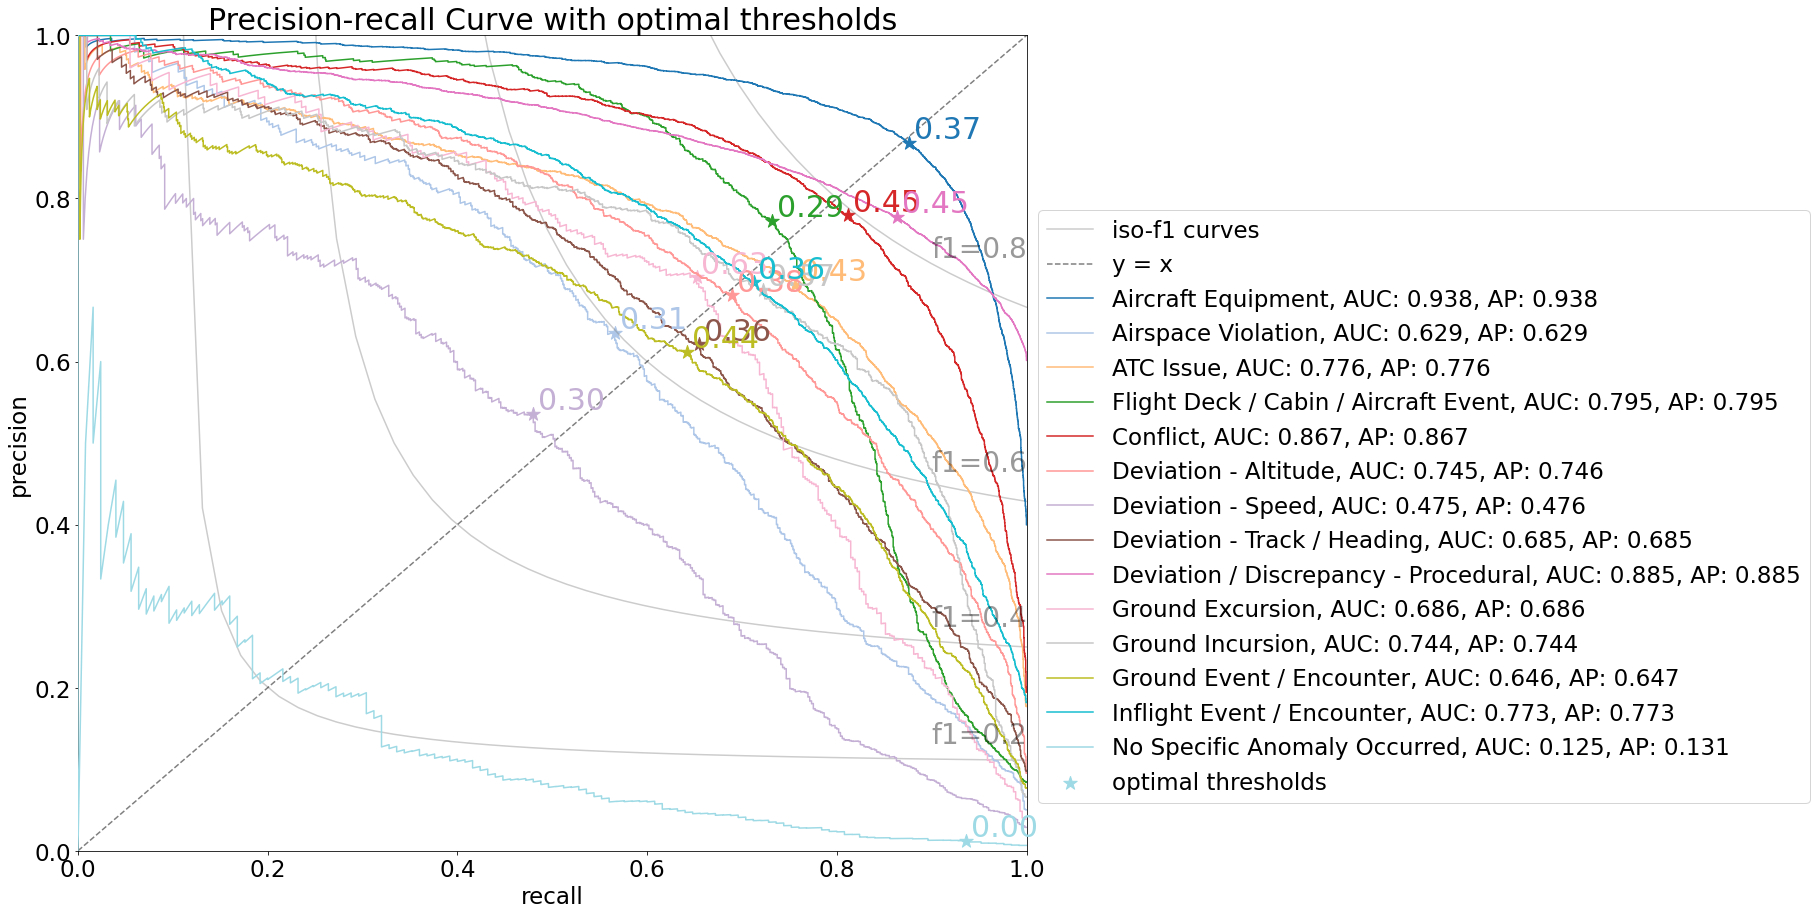

In [67]:
fig = plt.figure(figsize = (17,15))

lines = []  # Instantiate list of plot lines (i.e. curves) 
labels = [] # Instantiate list of plot labels

###########################################################################
### PLOT iso-f1 lines #######
f_scores = np.linspace(0.2, 0.8, num=4)
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha = 0.4, zorder = 2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02), size=28, alpha = 0.4)

# Store in our lists for now, we call them later
lines.append(l)
labels.append('iso-f1 curves')

# Plot diagonal
l, = plt.plot([0,1], [0,1], '--k', alpha = 0.5)
lines.append(l)
labels.append('y = x')

###########################################################################
### PLOT precision-recall lines #####
for anomaly, cls_idx in zip(anomalies, range(len(anomalies))):

  # Compute precision-recall pairs for different probability thresholds.
  y_test_cls, probs_cls = y_multilabel_to_binary(y_test, y_pred_proba, cls_idx)

  # Calculate precision, recall, thresholds
  precision, recall, thresholds = precision_recall_curve(y_test_cls, probs_cls)
 
  # calculate precision-recall AUC (Area Under Curve)
  auc = np.round(metrics.auc(recall, precision), 3)

  # calculate the average precision (AP)
  average_precision = average_precision_score(y_test_cls, probs_cls)
  average_precision = np.round(average_precision, 3)

  color = cmap(cls_idx) # use the same cmap as in the ROC curve
  l, = plt.plot(recall, precision, c = color, zorder=3) 
  # ax.plot() returns a tuple which contains only one element. 
  # If you assign it without the comma, you just assign the tuple.
  # using the comma, you unpack the tuple and get its element

  lines.append(l)
  labels.append(f'{anomalies[cls_idx][8:]}, AUC: {auc}, AP: {average_precision}') # slice the string, to ommit 'Anomaly_'

  # Plot optimum thresholds
  x = opt_recalls[cls_idx]
  y = opt_precisions[cls_idx]
  s = plt.scatter(x, y, marker = '*', s = 200, color = color)

  plt.annotate('{0:0.2f}'.format(opt_thresholds[cls_idx]), xy = (x + 0.005, y + 0.005), color = color, size=30, alpha = 1)
  
lines.append(s)
labels.append('optimal thresholds')
  

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('Precision-recall Curve with optimal thresholds')
plt.xlabel('recall')
plt.ylabel('precision')

plt.legend(lines, labels, bbox_to_anchor=(1, 0.8)); # here we use our lists of lines and labels

##### Evaluate using anomaly-specific thresholds as determined from PR curve

In [68]:
def y_prob_to_y_pred(y_pred_proba, threshold = 0.5):
  """
  Converts probabilities into 0's and 1's. We are still in the BINARY context.
  Input: monolabel predictions (probabilities), dimension = #samples
  Using a user-defined threshold, return a prediction vector 'y_pred' with 
  dimension = #samples, containing a '0' or a '1' for each sample
  """
  y_pred=[]
  for value in y_pred_proba:

    if value >= threshold:
      y_pred.append(1)
    else :
      y_pred.append(0)

  y_pred = np.array(y_pred)

  return y_pred

In [69]:
for anomaly, threshold, cls_idx in zip(anomalies, opt_thresholds, range(len(anomalies))):

  # Exctract the labels for the class of interest
  y_test_cls, probs_cls = y_multilabel_to_binary(y_test, y_pred_proba, cls_idx)

  # Convert the MULTILABEL probabilities into 0's and 1's, using the optimal threshold for each anomaly
  y_pred = y_prob_to_y_pred(probs_cls, threshold = threshold)
  thres_round = str(np.round_(threshold, 2))

  print(f"\n\n Classification Report for {anomaly}, \n using threshold = {thres_round}: \n\n", classification_report(y_test_cls, y_pred), "\n")



 Classification Report for Anomaly_Aircraft Equipment, 
 using threshold = 0.37: 

               precision    recall  f1-score   support

           0       0.92      0.91      0.92     11732
           1       0.87      0.88      0.87      7666

    accuracy                           0.90     19398
   macro avg       0.89      0.89      0.89     19398
weighted avg       0.90      0.90      0.90     19398
 



 Classification Report for Anomaly_Airspace Violation, 
 using threshold = 0.31: 

               precision    recall  f1-score   support

           0       0.98      0.99      0.98     18594
           1       0.64      0.57      0.60       804

    accuracy                           0.97     19398
   macro avg       0.81      0.78      0.79     19398
weighted avg       0.97      0.97      0.97     19398
 



 Classification Report for Anomaly_ATC Issue, 
 using threshold = 0.43: 

               precision    recall  f1-score   support

           0       0.95      0.94     